# Single observation hyperparameter inference (vers. 2)

Finally, we can do what we set out to do so many tutorials ago. If you're still here thank you for trudging through everything. 

We'll instantiate a Z2 Scalar Singlet model with Einasto density profile, a residual CCR background model, diffuse gamma ray background and localised HESS source catalogue backgrounds with a binning geometry from 0.1 TeV to 100 TeV and angular coords between -3 and 3 degrees with an 30 and 20 bins per decade for the energy axes and 0.1 and 0.2 angular resolutions for the true and reconstructed axes respectively.

We'll also set our pointing direction to the Galactic Centre and observation time to 5 hours.

In [1]:
from gammabayes import GammaBinning
from gammabayes.priors import HESSCatalogueSources_Prior, FermiGaggeroDiffusePrior, ObsFluxDiscreteLogPrior
from gammabayes.dark_matter import CombineDMComps, Z2_ScalarSinglet
from gammabayes.dark_matter.density_profiles import Einasto_Profile
from gammabayes.hyper_inference import MTree
from gammabayes.likelihoods.irfs import IRF_LogLikelihood


import numpy as np
from astropy import units as u

pointing_direction = np.array([0., 0.])*u.deg
observation_time = 5*u.hr

true_binning_geometry = GammaBinning(energy_axis=np.logspace(-1, 2, 91)*u.TeV, 
                                        lon_axis=np.linspace(-3, 3, 61)*u.deg, 
                                        lat_axis=np.linspace(-3, 3, 60)*u.deg)
recon_binning_geometry = GammaBinning(energy_axis=np.logspace(-1, 2, 61)*u.TeV, 
                                        lon_axis=np.linspace(-3, 3, 31)*u.deg, 
                                        lat_axis=np.linspace(-3, 3, 30)*u.deg)


irf_loglike = IRF_LogLikelihood(
    pointing_dir=pointing_direction,
    observation_time=observation_time,
    binning_geometry = recon_binning_geometry,
    true_binning_geometry=true_binning_geometry,
)

dark_matter_prior = CombineDMComps(
    name='DM',
    spectral_class=Z2_ScalarSinglet,
    spatial_class=Einasto_Profile,
    axes = true_binning_geometry.axes,
    binning_geometry=true_binning_geometry,
    irf_loglike=irf_loglike,
    pointing_dir=pointing_direction,
    observation_time=observation_time,
)

diffuse_prior = FermiGaggeroDiffusePrior(
    binning_geometry=true_binning_geometry,
    pointing_dir=pointing_direction,
    observation_time=observation_time,
    irf_loglike=irf_loglike
)


hess_prior = HESSCatalogueSources_Prior(
    binning_geometry=true_binning_geometry,
    pointing_dir=pointing_direction,
    observation_time=observation_time,
    irf_loglike=irf_loglike
)


ccr_prior = ObsFluxDiscreteLogPrior(
    name='CCR_BKG',
    logfunction=irf_loglike.log_bkg_CCR,
    binning_geometry=true_binning_geometry,
    pointing_dir=pointing_direction,
    observation_time=observation_time,
    irf_loglike=irf_loglike
)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:121: RuntimeWarning: divide by zero encountered in log
  self.log_normalisations = np.logaddexp(self.log_normalisations, np.log(annihilation_fractions[channel]))
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:126: RuntimeWarning: divide by zero encountered in log
  new_annihilation_fractions = np.exp(np.log(annihilation_fractions[channel])-self.log_normalisations)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/astro_sources/diffuse_emission/fermi_ga

## Simulate Event Data

We'll then construct simulate $500$ events with 50% coming from dark matter, 50% to the background with 70%, 20% and 10% for the CCR, local and diffuse for the background components. 

In [2]:
num_events = int(5e2)
signal_fraction = 0.5
ccr_frac = 0.7
local_frac = 0.2
diffuse_frac = 0.1

true_event_data = diffuse_prior.sample(num_events*(1-signal_fraction)*diffuse_frac)
true_event_data+=hess_prior.sample(num_events*(1-signal_fraction)*local_frac)
true_event_data+=ccr_prior.sample(num_events*(1-signal_fraction)*ccr_frac)
true_event_data+=dark_matter_prior.sample(num_events*signal_fraction)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:223: RuntimeWarning: divide by zero encountered in log
  log_channel_comp = np.log(channel_comp) - np.log((energy*u.TeV).to(self.inverse_output_unit).value) - np.log(np.log(10))


array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

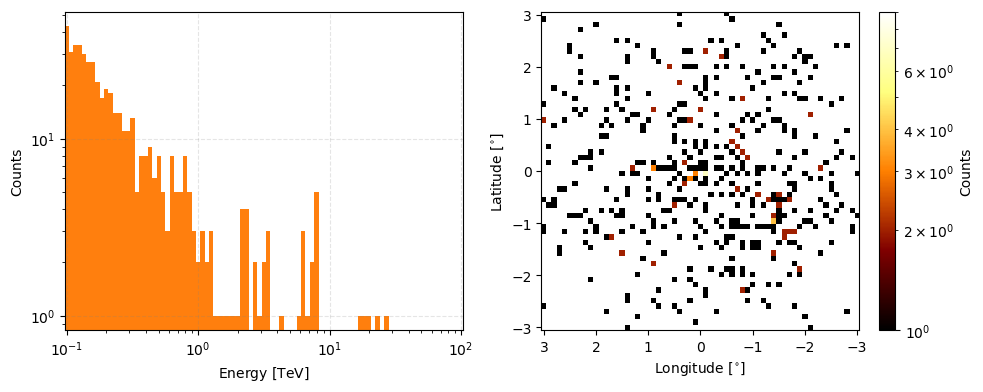

In [3]:
true_event_data.peek(count_scaling='log', figsize=(10,4))

Adding noise...

In [4]:
measured_event_data = irf_loglike.sample(true_event_data, print_progress=True)

  0%|          | 0/492 [00:00<?, ?it/s]/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/irf_extractor_class.py:276: RuntimeWarning: divide by zero encountered in log
  return np.log(adjusted_edisp_val)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/irf_extractor_class.py:302: RuntimeWarning: divide by zero encountered in log
  output = np.log(self.psf_default.evaluate(energy_true=true_energy,
100%|██████████| 492/492 [00:25<00:00, 19.02it/s]


array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

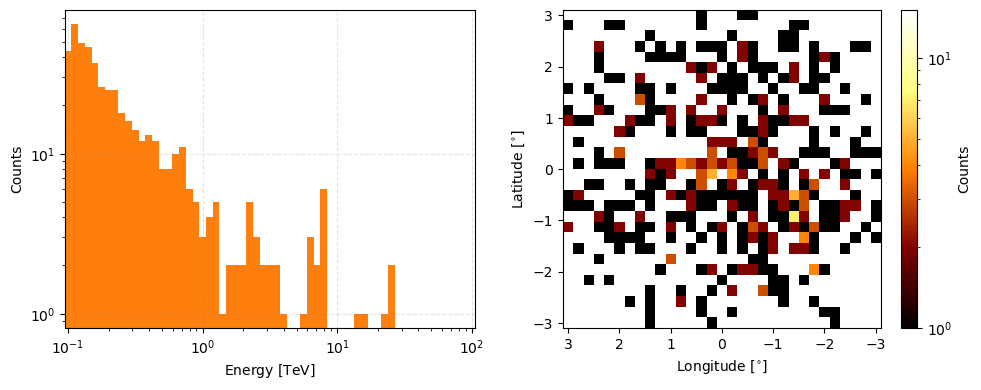

In [5]:
measured_event_data.peek(count_scaling='log', figsize=(10,4))

## Marginalise nuisance parameters

Now we need to specify what observational prior parameters we are interested in and how we wish to explore them. For the first step of inference we will require the `ParameterSet` for each prior where each set is independent of the other (regardless of whether this is true or not, prime example being the dark matter mass).

In [6]:
from gammabayes import ParameterSet

shared_parameter_specification = {}

parameter_specifications = [ ParameterSet({'spectral_parameters':
                                 {'mass':
                                  {'name': 'mass',
                                    'discrete': True,
                                    'scaling': 'log10',
                                    'bounds': 'event_dynamic',
                                    'absolute_bounds': [1.2e-1, 8e1], # Values that the event dynamic bounds cannot go passed
                                    'parameter_type': 'spectral_parameters',
                                    'dynamic_multiplier': 5,
                                    'num_events': 1e1,
                                    'default_value': 1.,
                                    'bins': 121}
                                    }
                                    })
                                    ]

# Specifying empty parameters
parameter_specifications.append(ParameterSet({})) 
parameter_specifications.append(ParameterSet({}))
parameter_specifications.append(ParameterSet({}))

parameter_specifications

[{'mass': {'name': 'mass', 'discrete': True, 'scaling': 'log10', 'bounds': [0.12, 38.11876574469643], 'absolute_bounds': [0.12, 80.0], 'parameter_type': 'spectral_parameters', 'dynamic_multiplier': 5.0, 'num_events': 10.0, 'default_value': 1.0, 'bins': 121, 'axis': array([ 0.12      ,  0.1259015 ,  0.13209322,  0.13858945,  0.14540516,
         0.15255607,  0.16005864,  0.16793019,  0.17618885,  0.18485366,
         0.19394461,  0.20348264,  0.21348974,  0.22398898,  0.23500456,
         0.24656189,  0.25868759,  0.27140962,  0.28475731,  0.29876143,
         0.31345426,  0.32886967,  0.3450432 ,  0.36201212,  0.37981557,
         0.39849457,  0.41809219,  0.4386536 ,  0.46022621,  0.48285974,
         0.50660637,  0.53152083,  0.55766057,  0.58508583,  0.61385985,
         0.64404895,  0.67572272,  0.70895418,  0.74381994,  0.78040036,
         0.81877978,  0.85904666,  0.90129384,  0.94561869,  0.9921234 ,
         1.04091518,  1.09210649,  1.14581534,  1.20216555,  1.26128702,
     

Additionally, we do not require the IRFs to be immediately normalised when called, this is due to various reasons but mainly that it ensures numerical stability. All you need are the integrated IRF values for each combination of true values in your `true_binning_geometry` but I have made an auxillary class called `FOV_IRF_Norm` that makes this, among other things, easer but I'll add more detail about this in the multi-observation inference tutorial.

It will take about 3 minutes to fill in all these values.

In [7]:
from gammabayes.hyper_inference import DiscreteAdaptiveScan
from gammabayes.likelihoods.irfs import FOV_IRF_Norm


log_likelihood_normalisation = FOV_IRF_Norm(
    true_binning_geometry=true_binning_geometry, 
    recon_binning_geometry=recon_binning_geometry, 
    original_norm_matrix_pointing_dir= pointing_direction,
    new_pointing= pointing_direction,
    pointing_dirs = [pointing_direction],
    irf_loglike=irf_loglike
    )

Filling in buffer: 100%|██████████| 91/91 [02:32<00:00,  1.68s/it]


And then all one would need to do is evaluate the priors and IRFs across the true binning geometry and numerically integrate appropriately. 

However, much of this grid has such low probabilities that they make negligible impact on the results. For this reason `GammaBayes` contains the `DiscreteAdaptiveScan` class, which takes in the prior, IRF, IRF log normalisation and parameter specifications and numerically integrates within the set of bounds. 

The input `[['log10', 0.5], ['linear', 0.5], ['linear', 0.5]]` means that energy values within 0.5 in magnitude and angular values within 0.5 degrees will be explored/integrated. You can compare these widths to those of the IRFs to see how they compare. 

But for now we put this information into `DiscreteAdaptiveScan` and it will (hopefully) handle the hard stuff.

___Note: The parameter specifications must be in the same order as the input priors___

In [8]:
from gammabayes import Parameter, ParameterSet, ParameterSetCollection


nuisance_marg_method = DiscreteAdaptiveScan(
    log_priors = [dark_matter_prior, ccr_prior, hess_prior, diffuse_prior], 
    log_likelihood = irf_loglike, 
    axes =recon_binning_geometry.axes,
    nuisance_axes = true_binning_geometry.axes,
    prior_parameter_specifications = parameter_specifications, 
    log_likelihoodnormalisation= log_likelihood_normalisation,
    bounds=[['log10', 0.5], ['linear', 0.5], ['linear', 0.5]]
)

To get the log marginalised probabilities you then need to call the `nuisance_log_marginalisation` method passing in the __measured__ event data. It does not have to be a `GammaObs` instance, but an array of size Nx3 with each row being energy, longitude and latitude values. 

I use `GammaObs` here as it creates this matrix with only the unique energy, longitude and latitude combinations decreasing computation time (especially for larger numbers of events).

In [9]:
log_marg_results = nuisance_marg_method.nuisance_log_marginalisation(measured_event_data=measured_event_data)

The sizes of the outputs should be (number of unique events, *shapes of discrete parameter values being explore*) or (number of events, *shapes of discrete parameter values being explore*) if using the raw measurement values. 

In this case we had 500 events and only passed in the unique measurements, so the shapes should be something slightly less than 500 by 121 for the dark matter priors and then just the rough number of events for the backgrounds as we didn't introduce any parameters for them.

In [10]:
[marg_results.shape for marg_results in log_marg_results]

[(480, 121), (480,), (480,), (480,)]

## Hyperparameter analysis

Now we want to combine these results and produce a combined posterior. To do this we need some standard way to store how the observational priors are related to each other. 

Unfortunately, this is one of the things in `GammaBayes` that is very much enforced, you have to use a class called `MTree` which is a specific instance of a common data tree structure for use in `GammaBayes` for this exact purpose.

We;ve tried to make it as user friendly as possible but if you have any particular difficulties with it hopefully the below example helps.

In [11]:
from gammabayes.hyper_inference import MTree

mixture_tree = MTree()

mixture_tree.create_tree(layout=[
    "DM",
    {'bkg':[ccr_prior.name, hess_prior.name, diffuse_prior.name]}
])

mixture_tree

___ID Structure___:
root __
    |__ DM
    |__ bkg
    |   |__ CCR_BKG
    |   |__ HESSCatalogueSources_Prior
    |   |__ FermiGaggeroDiffusePrior



___Leaf Values___:
('DM', 0.5)
('CCR_BKG', 0.16666666666666666)
('HESSCatalogueSources_Prior', 0.16666666666666666)
('FermiGaggeroDiffusePrior', 0.16666666666666666)

__Nodes__:
TreeNode(value=1.0, id=root)
TreeNode(value=0.5, id=DM)
TreeNode(value=0.5, id=bkg)
TreeNode(value=0.3333333333333333, id=CCR_BKG)
TreeNode(value=0.3333333333333333, id=HESSCatalogueSources_Prior)
TreeNode(value=0.3333333333333333, id=FermiGaggeroDiffusePrior)

Now that we have all these mixture values, we need to specify how we are going to analyse them. They follow the same inputs as standard parameters except now we are going to use the `Parameter` classes links to `scipy` and use custom distributions for the Dirichlet distributions. We will presume no information about any of the mixture parameters so all the alpha values will equal one. 

Otherwise, things to keep in mind when specifying these:
- they have to share the same names as the nodes in the mixture tree above
- if a leave/node is specifically meant to be applied to a specific observation prior model, the name of this prior model has to be the one specified in the mixture tree and thus also here
- for parameters that are dependent on each other, the first parameter mentioned needs to have all the relevant information including what other parameters are dependent on/with it but otherwise all you need to do after that for the other dependent parameters is state that they exists and whether they are continuous or discrete (in this case all mixture parameters might as well be continuous)

In [12]:
mixture_parameter_specifications = {
        'DM':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['bkg'],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': [
                    1., 
                    1.]}},

        'bkg':
            {'discrete': False,
            'bounds': [0., 1.],
            'dependent': ['DM'],
            'custom_dist_name': 'dirichlet',
            'custom_dist_kwargs': 
                {'alpha': 
                    [1., 
                    1.]}},

        'CCR_BKG':
            {'discrete': False,
             'bounds': [0., 1.],
            'dependent': ['HESSCatalogueSources_Prior', 'FermiGaggeroDiffusePrior', ],
            'custom_dist_name': 'dirichlet', 'custom_dist_kwargs': {'alpha': [ 1., 1.,1.]}},

        'HESSCatalogueSources_Prior':{'discrete': False,'bounds': [0., 1.],},

        'FermiGaggeroDiffusePrior':{'discrete': False,'bounds': [0., 1.],},
        
    }

From there we need to provide a mapping between the unit cube produced by a nested sampler or the like, the mixture parameters and the relevant slices of the log marginalised probability results above.


This can be done with `ScanOutput_StochasticTreeMixturePosterior` which used to be one of several samplers in `GammaBayes` hence the horrendous name. One can pass in the above information and produce a prior transform and likelihood which you can use outside of `GammaBayes`.

We also need to re-introduce the number of times each unique event value is repeated. This is done with the `meas_event_weights` variable which is the second part of the `nonzero_bin_data` tuple, the first part is used for the unique coordinate values used above.

In [13]:
import sys, time, os
from gammabayes.high_level_inference.general_mixture.hyperparameter_posterior_sampling import high_level_mixture
from gammabayes.hyper_inference import ScanOutput_StochasticTreeMixturePosterior
from dynesty.pool import Pool as DyPool
from dynesty import NestedSampler


import numpy as np



meas_event_weights = measured_event_data.nonzero_bin_data[1]



meas_event_weights = np.array(meas_event_weights)


hyper_mix_instance = ScanOutput_StochasticTreeMixturePosterior(
    mixture_tree = mixture_tree,
    log_nuisance_marg_results= log_marg_results,
    mixture_parameter_specifications= mixture_parameter_specifications,
    prior_parameter_specifications = parameter_specifications, 
    shared_parameters = shared_parameter_specification,
    event_weights = meas_event_weights,
)


hyper_loglike = hyper_mix_instance.ln_likelihood
hyper_prior_transform = hyper_mix_instance.prior_transform
ndim = hyper_mix_instance.ndim


You can now use the `hyper_loglike` and `hyper_prior_transform` functions however you wish.

In [14]:
hyper_loglike([0.1,  0.9, 1/3, 1/3, 1/3, 10.0,])

-2682.699422669699

For now, let's pass these into a nested sampler and run it.

In [15]:
sampler = NestedSampler(prior_transform=hyper_prior_transform,
                        loglikelihood=hyper_loglike,
                        ndim=ndim, nlive=500)

In [16]:
sampler.run_nested(dlogz=0.8)

4420it [02:49, 26.04it/s, +500 | bound: 477 | nc: 1 | ncall: 376676 | eff(%):  1.308 | loglstar:   -inf < -2609.002 <    inf | logz: -2617.587 +/-  0.140 | dlogz:  0.002 >  0.800]


Extracting the samples and their respective weights we find the below corner plot. And we should be able to reconstruct the true values within 1 to 3 sigmas, or more if you're really unlucky.

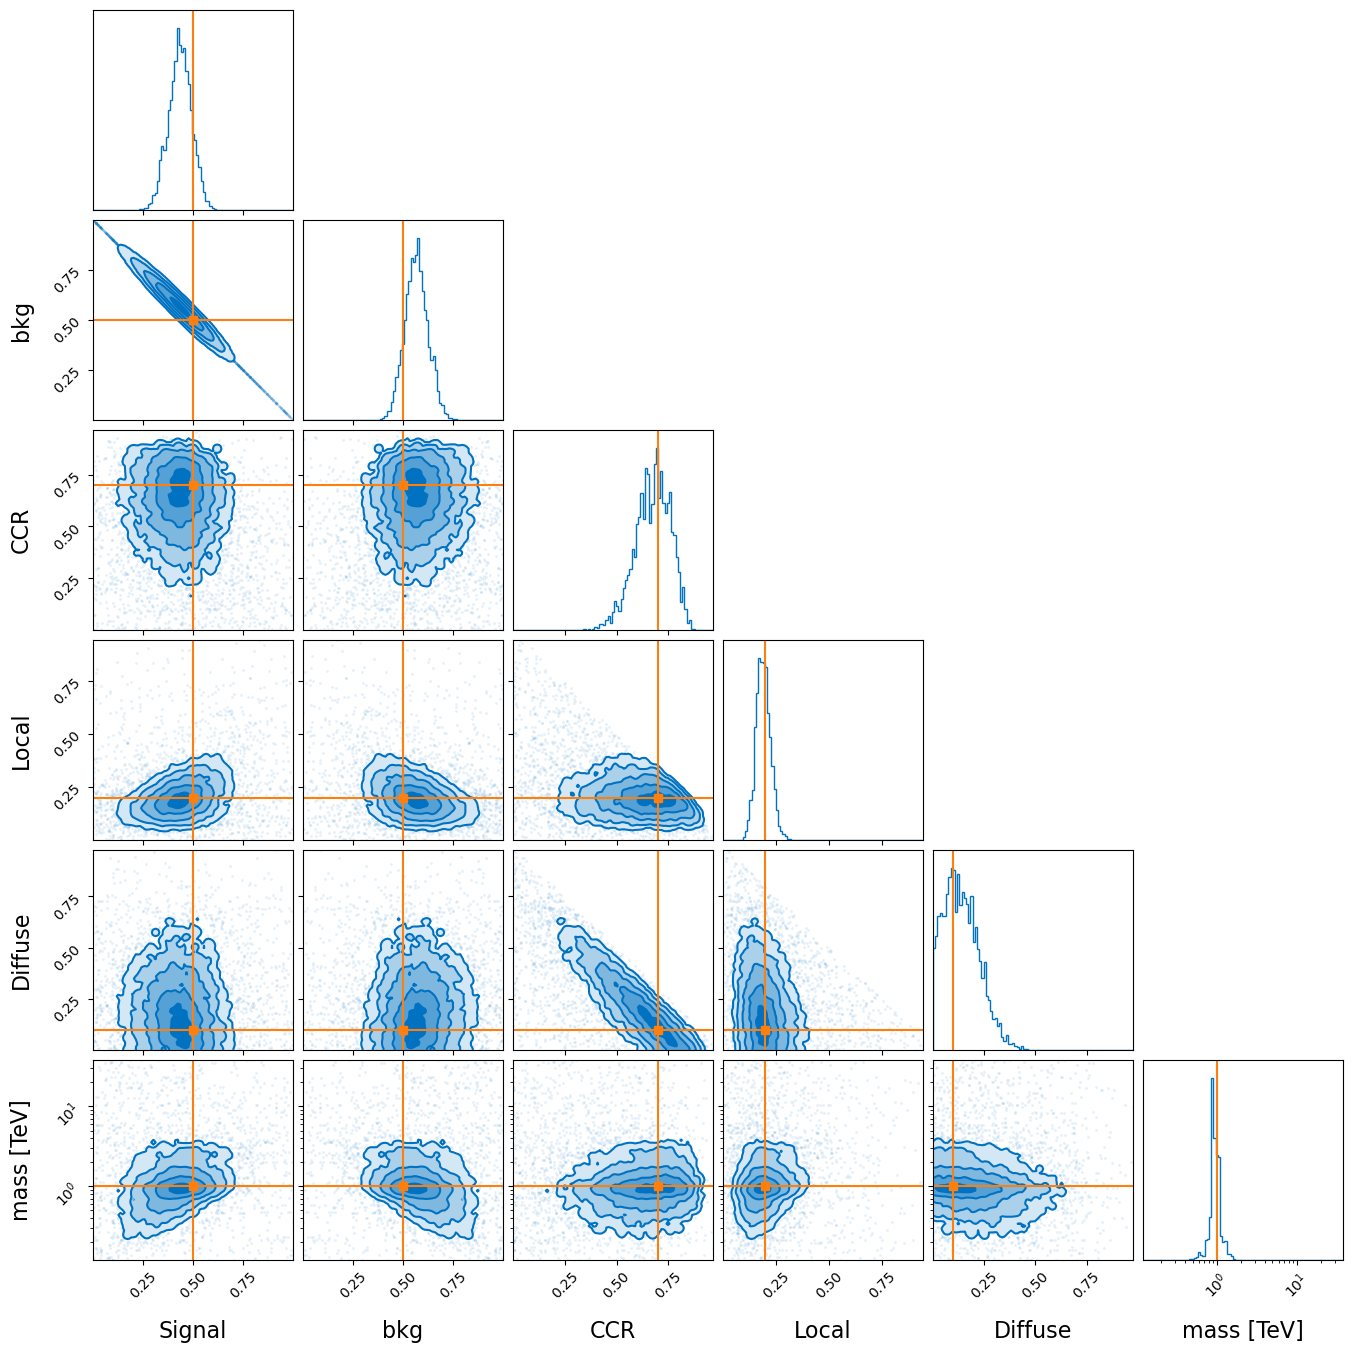

In [17]:
from gammabayes.utils.plotting import defaults_kwargs
from matplotlib import pyplot as plt
from corner import corner

sampling_results = sampler.results


corner(sampling_results.samples, 
       weights=np.exp(sampling_results.logwt-np.mean(sampling_results.logwt)),
       labels=['Signal',  'bkg', 'CCR', 'Local', 'Diffuse', 'mass [TeV]'],
       truths = [signal_fraction, 1-signal_fraction, ccr_frac, local_frac, diffuse_frac, 1.],
       axes_scale=[*['linear']*5, 'log',],
       bins=91,
       **defaults_kwargs
       )
plt.show()


Now you essentially have everything you need to know to perform your own inference. 

However, in the next tutorial we provide some more information about how to use data from multiple separate observations to perform this kind of inference. 